# Introduction to Astrometry Notebook

We're going to take sources from an HSC observation and match them to Gaia, look at the separations, then fit the wcs and look at  focal plane distortions, finally we'll look at the effect of proper motions, then apply proper motions and parallax and redo the fit. 

If that is too fast, also fit the source positions.
Potential extras: do a better fit using error of measurements, try to find bug in astropy proper motion.

#### First, load some helpful packages:

In [1]:
# Start by loading some helpful packages:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.wcs
import astropy.units as u
from astropy.io import fits
from astropy import wcs
import pandas as pd
from glob import glob
import re

Normally, I wouldn't recommend suppressing warning messages, but in this case astropy will complain a lot about the input files, so it's helpful here:

In [2]:
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

## Part 1: Fitting a WCS

#### 1. Matching sources to a reference catalog

We start by loading the sample data sets. In the "astrometry_data" subdirectory, there are files containing the sources measured in one HSC exposure. There is one file for each detector. These source catalogs only contain isolated stars that are appropriate for fitting the astrometric solution (i.e., there are no galaxies or stars that are close to galaxies). There is also one file with a subset of the Gaia catalog overlapping the footprint of the HSC exposure.

First, load the Gaia catalog:
(In this Gaia catalog, missing entries are denoted by NaNs, so you probably want to filter these out.)

In [46]:
gaia_cat = pd.read_parquet('astrometry_data/gaia_refCat.parquet')
good_ids = np.isfinite(gaia_cat['coord_ra'])
gaia_skyCoord = SkyCoord(ra=gaia_cat['coord_ra'][good_ids]*u.radian,
                         dec=gaia_cat['coord_dec'][good_ids]*u.radian, frame='icrs')
print(gaia_skyCoord)

<SkyCoord (ICRS): (ra, dec) in deg
    [(151.08625144, 2.26910322), (151.1138923 , 2.2753019 ),
     (151.07714322, 2.27941641), ..., (149.60790663, 2.25564513),
     (149.58325668, 2.26242986), (149.60453964, 2.26563869)]>


The files "astrometry_data/1180_\<detector\>.fits" contain the sources from each detector for visit 1180. The fits files have a best guess for the WCS in the primary HDU and the table of sources in the second HDU.

Let's start by just looking at one source catalog:

In [47]:
sources = fits.open('astrometry_data/1180_42.fits')
source_cat = sources[1].data
# You can check the column names of the data:
print(source_cat.x)

[  86.92947   830.3061   1273.882     991.7234   1603.6173    669.77405
 1222.3792   1617.7659   1915.1594   1689.6992    988.5114    405.82425
 1993.8823   1853.9066   1543.8564   1767.1976   1361.6143    741.3336
 1576.8868   1589.507     740.0085   1995.4805   1348.4656   1347.6151
 1513.6931   1079.8676    423.1765   1953.6847    987.58795   632.06964
  399.5057    194.66345  1360.759    1928.748     708.2506    600.3489
 1245.5801   1958.7861   1343.57     1375.4844   1112.0184    317.6648
 1146.6028    216.21608  1759.0045   1979.2542    286.83063  1025.7056
  325.2598    958.09875  1727.1836   1132.749    1903.9978    670.6934
 1051.7379   1189.1149   1506.7557    193.13037    43.88585   146.65303
 1991.1487    938.66943  1970.9211   1833.6049   1753.1633   1170.0454
  610.2953   1310.683    1733.8594    487.3185    780.8097    923.81604
 1992.095     462.21704  1188.9022    583.31793  1154.5541    623.78625
 2025.1869   1849.7136   1778.734    1313.3827   1235.4691   1823.338
 

Now convert the source catalog pixel values to RA and Dec using the WCS in the header

In [52]:
detector_wcs = wcs.WCS(sources[0].header)

# Hint: wcs has a pixel_to_world method that is helpful here
source_ra, source_dec = detector_wcs.pixel_to_world_values(source_cat.x, source_cat.y)
source_skyCoords = SkyCoord(ra=source_ra*u.degree, dec=source_dec*u.degree)
print(source_skyCoords)

<SkyCoord (ICRS): (ra, dec) in deg
    [(150.00962882, 2.08628661), (150.01077289, 2.12105591),
     (150.01187552, 2.14180264), (150.01244033, 2.12860488),
     (150.01331644, 2.15722449), (150.01554761, 2.11354445),
     (150.01549671, 2.13939151), (150.01556619, 2.1578849 ),
     (150.01585936, 2.17179473), (150.01588108, 2.16124926),
     (150.01632701, 2.1284523 ), (150.01765772, 2.10119743),
     (150.01752958, 2.17547582), (150.01831346, 2.16892826),
     (150.01967678, 2.15442545), (150.02119444, 2.16487087),
     (150.02264069, 2.14589962), (150.02314703, 2.11688689),
     (150.02304536, 2.15596833), (150.0243618 , 2.15655781),
     (150.02441177, 2.11682414), (150.02518344, 2.17554592),
     (150.02699378, 2.14528196), (150.03029715, 2.14524015),
     (150.03172811, 2.15300725), (150.03225673, 2.13271557),
     (150.03378377, 2.10199918), (150.03562075, 2.1735846 ),
     (150.03592291, 2.12839711), (150.03671457, 2.11176794),
     (150.03739596, 2.10088978), (150.03834579, 2.

Make a plot showing the RA and Dec positions of the two catalogs to make sure we are starting with something sensible. For example, first make sure that the RA and Dec values of the two catalogs overlap, which they should. (Mixing up degrees and radians happens all the time!) Does it look like there are any likely matches between the catalogs? I recommend using different markers for each catalog in your scatter plot.

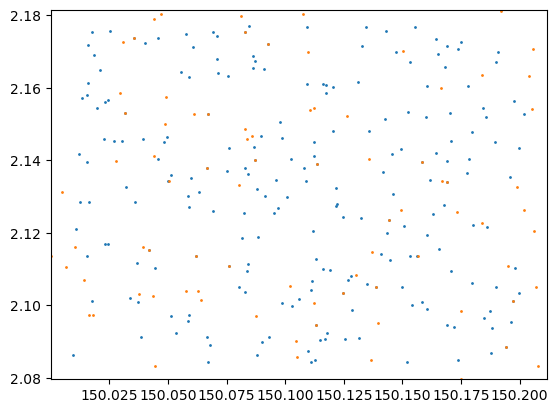

In [61]:
fig, ax = plt.subplots()
ax.scatter(source_skyCoords.ra, source_skyCoords.dec, s=1)
ax.set_xlim(auto=False)
ax.set_ylim(auto=False)
ax.scatter(gaia_skyCoord.ra, gaia_skyCoord.dec, s=1)

Given the initial estimate of RA and Dec, match the Gaia catalog sources to the new source catalog:

In [93]:
# Complete: 
# (Hint: astropy SkyCoord has a "match_to_catalog_sky" function that works well for this.)

idx, d2d, d3d = source_skyCoords.match_to_catalog_sky(gaia_skyCoord)
print(idx)
d2d = np.array(d2d/u.degree)*60**2
print(len(idx))
print(len(d2d)) #idx are index in gaia_skyCoord
print(len(gaia_skyCoord))

[ 8588  8603  8604  8604  8608  8603  8605  8608 10169  8608  8604  8589
 10169  8631  8608  8608  8605  8603  8608  8608  8600  8631  8605  8605
  8607  8605  8596  8630  8598  8598  8596  8579  8606  8630  8597  8597
  8606  8632  8623  8623  8601  8599  8601  8580  8624  8633  8583  8601
  8583  8601  8620  8614  8633  8582  8614  8614  8621  8583  8574  8583
  8626  8614  8626  8625  8621  8615  8584  8619  8621  8584  8584  8615
  8625  8578  8616  8584  8616  8584  8625  8622  8622  8617  8616  8622
  8615  8578  8584  8617  8578  8616  8622  8622  8578  8616  8616  8616
  8617  8617  8613  4893  4893  8613  8613  4893  4893  4895  8577  4907
  8577  8612  8613  8612  4893  8577  4893  8611  8612  4893  8611  8612
  4896  8611  4896  8611  4896  4888  4894  4894  4893  4893  4893  4888
  4889  4685  4887  4887  4888  4894  4685  4889  4906  4906  4687  4892
  4687  4889  4892  4892  4903  4890  4890  4889  4892  4891  4903  4898
  4688  4891  4680  4898  4903  4688  4688  4903  4

Not every source in the catalog will have a match in the Gaia catalog. Make a histogram of the match separations and choose a sensible limit for the distance between matches.

(array([21.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  2.,
         1.,  2.,  0.,  0.,  3.,  0.,  1.,  3.,  3.,  3.,  3.,  2.,  2.,
         1.,  1.,  3.,  4.,  1.,  3.,  5.,  5.,  8.,  1.,  2.,  0.,  5.,
         3.,  1.,  5.,  6.,  3.,  2.,  4.,  3.,  6.,  6.]),
 array([ 0.        ,  0.6122449 ,  1.2244898 ,  1.83673469,  2.44897959,
         3.06122449,  3.67346939,  4.28571429,  4.89795918,  5.51020408,
         6.12244898,  6.73469388,  7.34693878,  7.95918367,  8.57142857,
         9.18367347,  9.79591837, 10.40816327, 11.02040816, 11.63265306,
        12.24489796, 12.85714286, 13.46938776, 14.08163265, 14.69387755,
        15.30612245, 15.91836735, 16.53061224, 17.14285714, 17.75510204,
        18.36734694, 18.97959184, 19.59183673, 20.20408163, 20.81632653,
        21.42857143, 22.04081633, 22.65306122, 23.26530612, 23.87755102,
        24.48979592, 25.10204082, 25.71428571, 26.32653061, 26.93877551,
        27.55102041, 28.16326531, 28.7755102 , 29.3877551 , 30. 

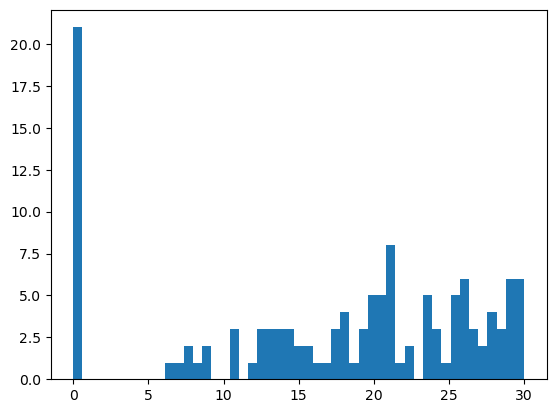

In [84]:
fig,ax = plt.subplots()
ax.hist(d2d, bins=np.linspace(0,30)) # shows distinct populations, which looks like true and false matches

Make a histogram of just the good matches to see what the separations look like.

(array([6., 4., 2., 1., 2., 1., 2., 1., 0., 2.]),
 array([0.01583281, 0.04951345, 0.08319408, 0.11687472, 0.15055536,
        0.184236  , 0.21791663, 0.25159727, 0.28527791, 0.31895855,
        0.35263918]),
 <BarContainer object of 10 artists>)

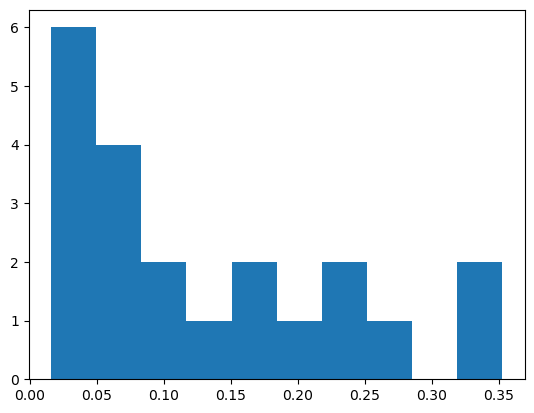

In [97]:
good_idx = idx[d2d<1]

fig,ax = plt.subplots()
ax.hist(d2d[d2d<0.5])

You may also want to remove any sources that have ambiguous pairings (within the limit you selected above) -- i.e. one gaia star matches multiple science sources or vice-versa

#### 2. Fitting a WCS

Now that we have found the stars that are in both our science image and our reference catalog, let's try to fit an improved WCS.

To do a simple version of this, use `astropy.wcs.utils.fit_wcs_from_points` to fit a WCS function. Use the optional argument `sip_degree` to choose what order of polynomial to use for the function. (Choosing zero should give something pretty close to the WCS we got from the fits file header.) The pixel values should come from our source catalog, and the sky coordinates should come from the Gaia catalog.

In [100]:
idx_source, idx_gaia, d2d, d3d = gaia_skyCoord.search_around_sky(source_skyCoords, 1*u.deg/(3600))

print(idx_gaia-good_idx)# check they're same

new_wcs = wcs.utils.fit_wcs_from_points((source_cat.x[idx_source], source_cat.y[idx_source]),
                                        gaia_skyCoord[idx_gaia], sip_degree=3)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Now calculate the RA and Dec for the pixel coordinages in the input image and see if the separations between the science image and Gaia have improved.

In [ ]:
new_radec = # complete

#### 3. Fit the WCS over the whole focal plane and look for camera-level effects

We are going to put the above steps together in a loop over all the detectors to get an improved WCS for each detector. 

In [ ]:
source_files = glob('astrometry_data/1180_*.fits')
get_detector = re.compile(r'astrometry_data/1180_(\d+?).fits')
orig_wcs_dict = {}
new_wcs_dict = {}
for source_file in source_files:
    sources = # complete
    
    s = get_detector.search(source_file)
    detector = int(s.group(1))

    orig_wcs_dict[detector] = # complete

    source_cat = # complete

    source_coords = # complete

    # Choose good matches as above...

    new_wcs = # complete
    new_wcs_dict[detector] = new_wcs


Plot the difference in RA and Dec vs the simple wcs position, then look at this difference over the focal plane. Are there coherent distortions between detectors?

To do this, I recommend making a grid in x and y pixel values and calculating what RA and Dec those map to using the original and new WCSs for each detector. 

In [ ]:
x_range = np.arange(0, 2048, 100)
y_range = np.arange(0, 4096, 100)

# complete

#### 4. How good is the model?

Use the pixel scale matrix (the CD matrix) to approximate the WCS Jacobian and propagate the x and y errors to RA and Dec. You can use this equation for the error propagation:

$$ \mathbf{C}_{RA, Dec} = \mathbf{J} \mathbf{C}_{x, y} \mathbf{J}^T
$$

where $\mathbf{C}_{x, y}$ is the x,y covariance matrix, \mathbf{C}_{RA, Dec} is the covariance in RA and Dec, and \mathbf{J} is the Jacobian of the WCS transformation.


In [ ]:
print(new_wcs.pixel_scale_matrix)

Using this covariance, calculated the chi-squared of the model for the WCS that we have calculated.